# NOAA-CIRES Reanalysis temperature data

The NOAA-CIRES [Twentieth Century Reanalysis (V2)](https://psl.noaa.gov/data/gridded/data.20thC_ReanV2.html) project provides objectively analyzed four-dimensional (latitude, longitude, height, time) weather data and their uncertainty.
Data are available from 1871 January 1 through 2012 December 31,
and are presented with 6-hr, daily, and monthly means
on a 2.5-degree latitude x 2.5-degree longitude global grid
at multiple pressure levels in the atmosphere, from the surface to 10 mb.

The [GitHub repository](https://github.com/csdms/reccs-2021/) for this workshop includes a Twentieth Century Reanalysis (V2) dataset that contains daily mean 500 mb [geopotential height](https://en.wikipedia.org/wiki/Geopotential_height) data for a single day in 2010.

The goal of this exercise is to read these data into this notebook and display them.

The data are in [NetCDF](https://en.wikipedia.org/wiki/NetCDF), a data storage format that's ubiquitous in the geosciences. Over the years, there have been several libraries developed in Python to read and write NetCDF files, including:

* scipy.io.netcdf
* netcdf4
* xarray

The last, [*xarray*]((http://xarray.pydata.org/en/stable/)), is the current best choice for working with NetCDF.
(It's really amazing.)
However, this example is old--I think I wrote it first in 2011--and rather than rewrite it to use *xarray*, I kept the original library.
I think this shows the power of a well-written Python library:
it continues to work even after it's been superseded by a newer technology.

Start by importing libraries used in this example. There are several.

In [1]:
import time
import calendar
import math
import numpy as np
from scipy.io import netcdf
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

Because there's a bit of work required to read, prepare, and plot the data, I've broken the work into steps, each with a function to do the work of the step.

The first is a function called *read*:

In [2]:
def read(reanalysis_file):
    """ Reads data from a NOAA-CIRES 20th Century Reanalysis V2 file.

    The file is NetCDF. It contains global 2.5-deg daily mean 500 mb heights.
    
    Parameters
    ----------
    reanalysis_file : str
      The path to a 20CRv2 file.
      
    Returns
    -------
    dict
      A dictionary of data read from the file.

    """
    try:
        f = netcdf.netcdf_file(reanalysis_file, 'r', mmap=False)
    except IOError:
        print('File "' + reanalysis_file + '" cannot be read.')
        return

    data = {
        'file':f.filename,
        'level':f.variables['level'][0],
        'time':f.variables['time'], 
        'hgt':f.variables['hgt'], 
        'lat':f.variables['lat'], 
        'lon':f.variables['lon']
        }
    f.close()

    return data

Let's identify the data file and use the *read* function to load its contents.

In [3]:
rean_file = "../data/X174.29.255.181.65.14.23.9.nc"
rean_data = read(rean_file)
rean_data

{'file': '../data/X174.29.255.181.65.14.23.9.nc',
 'level': 500.0,
 'time': <scipy.io.netcdf.netcdf_variable at 0x198ba81c0>,
 'hgt': <scipy.io.netcdf.netcdf_variable at 0x197e73ee0>,
 'lat': <scipy.io.netcdf.netcdf_variable at 0x1075fdd00>,
 'lon': <scipy.io.netcdf.netcdf_variable at 0x198ba8220>}

**Discussion:** What happened here?

In [4]:
# Take a quick look at the file contents with a built-in NetCDF tool.

# !ncdump -h "../data/X174.29.255.181.65.14.23.9.nc"

To prepare the data for plotting, use another function, called *prep*:

In [5]:
def prep(rean_data):
    """Prepares 20th Century Reanalysis V2 for display.
    
    Converts data read from a NOAA-CIRES 20th Century Reanalysis V2
    file into more convenient formats. Returns a dict containing lon, lat
    and hgt as NumPy arrays, and time as list of struct_time tuples.
    
    Parameters
    ----------
    rean_data : dict
      A dict of data as returned from the `read` function.
      
    Returns
    -------
    dict
      A dict containing lon, lat and hgt as NumPy arrays, and time as list
      of struct_time tuples.

    """
    # Make a dict for storing results.
    data = {
        'lat' : rean_data['lat'].data, 
        'lon' : rean_data['lon'].data
        }

    # Apply scale_factor and add_offset properties to hgt variable.
    # Add to data dict.
    data['hgt'] = rean_data['hgt'].data * rean_data['hgt'].scale_factor \
                  + rean_data['hgt'].add_offset

    # Convert time variable (which is in hours since 0001-01-01) into
    # calendar dates. Add to data dict.
    start_time = '0001-01-01' # from rean_data['time'].units
    start_time_cal = time.strptime(start_time, '%Y-%m-%d')
    start_time_sec = calendar.timegm(start_time_cal)
    sec_in_hour = 60.0*60.0
    time_in_sec = rean_data['time'].data*sec_in_hour + start_time_sec
    time_in_struct_time = [time.gmtime(i) for i in time_in_sec]
    data['time'] = [time.strftime('%Y-%m-%d', j) for j in time_in_struct_time]

    return data

Pass the data read from the reanalysis file through the *prep* function:

In [6]:
prep_data = prep(rean_data)
prep_data

{'lat': array([ 90. ,  87.5,  85. ,  82.5,  80. ,  77.5,  75. ,  72.5,  70. ,
         67.5,  65. ,  62.5,  60. ,  57.5,  55. ,  52.5,  50. ,  47.5,
         45. ,  42.5,  40. ,  37.5,  35. ,  32.5,  30. ,  27.5,  25. ,
         22.5,  20. ,  17.5,  15. ,  12.5,  10. ,   7.5,   5. ,   2.5,
          0. ,  -2.5,  -5. ,  -7.5, -10. , -12.5, -15. , -17.5, -20. ,
        -22.5, -25. , -27.5, -30. , -32.5, -35. , -37.5, -40. , -42.5,
        -45. , -47.5, -50. , -52.5, -55. , -57.5, -60. , -62.5, -65. ,
        -67.5, -70. , -72.5, -75. , -77.5, -80. , -82.5, -85. , -87.5,
        -90. ], dtype=float32),
 'lon': array([  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,
         22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5,
         45. ,  47.5,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,
         67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,  85. ,  87.5,
         90. ,  92.5,  95. ,  97.5, 100. , 102.5, 105. , 107.5, 110. ,
        112.5, 115. , 117.5, 12

**Discussion:** What happened here?

The data are now ready to be plotted.

To perform this task, use a third function, *view*:

In [7]:
def view(prep_data, dayofyear=46, show=False, outfile='gph.png'):
    """Draws a contour plot of the mean 500 mb geopotential surface.
    
    Plot is for a specified day of the year with data from a NOAA-CIRES
    20th Century Reanalysis file. The plot can be saved to a PNG file.
    
    Parameters
    ----------
    prep_data : dict
      A dict of data returned from the `prep` function.
    day_of_year: int, optional
      An ordinal date.
    show : bool, optional
      Set this flag to display plot on screen; otherwise, write to file.
    outfile : str, optional
      Name of PNG file.

    """

    # Set up map projection.
    map = Basemap(projection='ortho',
                  lon_0=-105,
                  lat_0=60,
                  resolution='l')
    map.drawcoastlines()
    map.drawmapboundary()
    map.drawparallels(range(-90, 120, 30))
    map.drawmeridians(range(0, 420, 60))

    # Transform lat/lon into map coordinates (meters).
    x, y = map(*np.meshgrid(prep_data['lon'], prep_data['lat']))

    # Extract a single day of heights.
    hgt = prep_data['hgt'][dayofyear, 0, :, :]

    # Set up consistent contour levels so the colorbar doesn't change.
    delta = 100
    hgt_min = math.floor(prep_data['hgt'].min()/delta)*delta
    hgt_max = math.ceil(prep_data['hgt'].max()/delta)*delta
    clevels = np.arange(hgt_min, hgt_max, delta)

    # Draw contours of gph and annotate.
    c = map.contourf(x, y, hgt, levels=clevels, cmap=plt.cm.RdYlBu_r)
    cb = map.colorbar(c, 'right', size="3%", pad='5%')
    cb.set_label('Geopotential Height (m)')
    plt.title('500 mb Geopotential Heights : ' + prep_data['time'][dayofyear])
    plt.text(0.5*max(plt.axis()), -0.1*max(plt.axis()),
             'Data: NOAA-CIRES 20th Century Reanalysis, Version 2',
             fontsize=10,
             verticalalignment='bottom',
             horizontalalignment='center')

    # Either show plot or save it to a PNG file.
    if show is True:
        plt.show()
    else:
        plt.savefig(outfile, dpi=96)
        plt.close()

    return

Pass the prepared data into the *view* function to produce a plot.

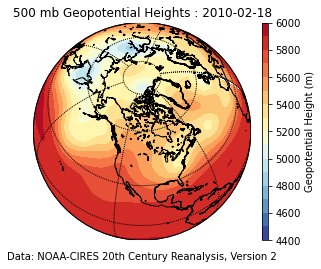

In [8]:
view(prep_data, show=True)

## Summary

That's it! Go forth and try new things in Python.